In [95]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime #for working with times objects
from datetime import timedelta #for working with times objects
from collections import Counter
import folium #map
import matplotlib.pyplot as plt #color and graph
import matplotlib.cm as cm #color
import math
import random
import glob
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [96]:
data = pd.read_csv("predict_bike_small.csv", low_memory=False)

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   end_station              686 non-null    int64  
 1   hour                     686 non-null    int64  
 2   avg_trip_count           686 non-null    float64
 3   idle_time                686 non-null    float64
 4   idle_bikes_count         686 non-null    int64  
 5   temperature              686 non-null    float64
 6   windspeed                686 non-null    float64
 7   bad_weather_condition    686 non-null    int64  
 8   month                    686 non-null    int64  
 9   season                   686 non-null    float64
 10  hour_sin                 686 non-null    float64
 11  hour_cos                 686 non-null    float64
 12  avg_duration_passholder  686 non-null    float64
 13  passholder_indego        686 non-null    int64  
 14  is_weekday               6

In [98]:
X = data.drop('idle_time', axis=1)  # Features
y = data['idle_time']  


In [99]:
# F-Test
f_scores, p_values = f_regression(X, y)

f_test_results = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores, 'p-value': p_values})

print(f_test_results)


                    Feature     F-Score        p-value
0               end_station    3.536423   6.045944e-02
1                      hour    0.213801   6.439512e-01
2            avg_trip_count    1.678521   1.955582e-01
3          idle_bikes_count  715.064900  2.198033e-108
4               temperature   14.430532   1.583689e-04
5                 windspeed    1.422146   2.334640e-01
6     bad_weather_condition    0.027666   8.679448e-01
7                     month    0.571777   4.498139e-01
8                    season    0.236207   6.271149e-01
9                  hour_sin    0.110855   7.392748e-01
10                 hour_cos    0.363189   5.469401e-01
11  avg_duration_passholder    0.758549   3.840885e-01
12        passholder_indego    1.435611   2.312658e-01
13               is_weekday    0.129413   7.191525e-01
14                POI_Count    6.920916   8.711149e-03
15            summer_winter    9.421320   2.229616e-03


We tried to drop some of the Features above but every time we tried to the values of MSE, MAE R2 got worse. 

In [100]:
drop_column = [] # we could use this to drop a Feature
X = data.drop(['idle_time'] + drop_column, axis=1)  # Features
y = data['idle_time'] / 60 

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



We tried to use grid for the best possible values of each parameter. But after some time it didn't compile in time so we used the last parameter for the following code.


param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],  # C values
    'kernel': ['linear', 'rbf', "poly"],  # kernel
    'epsilon': [0.1, 0.01, 0.001]  # epsilon
}

svr_model = SVR()
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train) 

print("Best Hyperparameter: ", grid_search.best_params_)

best_svr_model = grid_search.best_estimator_
y_pred = best_svr_model.predict(X_test_scaled) 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE) with best parameter: ", mse)
print("R-squared (R2) with best parameter: ", r2)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
df = pd.DataFrame({"Actual" : y_test, "Predicted" : y_pred})
df

In [101]:
svr_model = SVR(kernel='linear', C=10000.0, epsilon=0.1)

# train model
svr_model.fit(X_train_scaled, y_train)

SVR(C=10000.0, kernel='linear')

In [102]:
# Prediction
y_pred = svr_model.predict(X_test_scaled)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean absolute Error (MAE): 15.331161804046353
Mean Squared Error (MSE): 1093.2741026562226
R-squared (R2): 0.7565873333786648


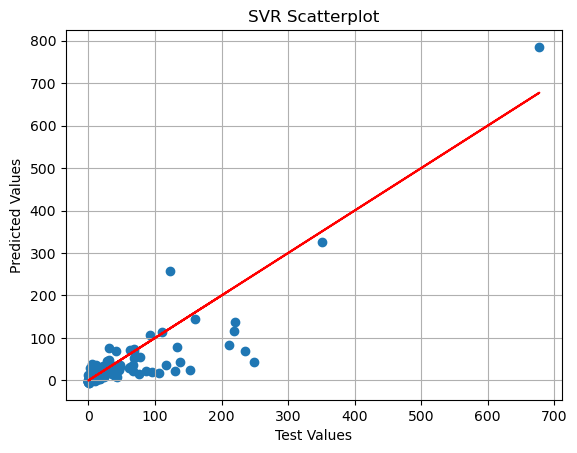

In [103]:
#Scatterplot SVR
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, c="r")
plt.xlabel('Test Values')
plt.ylabel('Predicted Values')
plt.title('SVR Scatterplot')
plt.grid()
plt.savefig("SVR_Scatter.jpg")
plt.show()


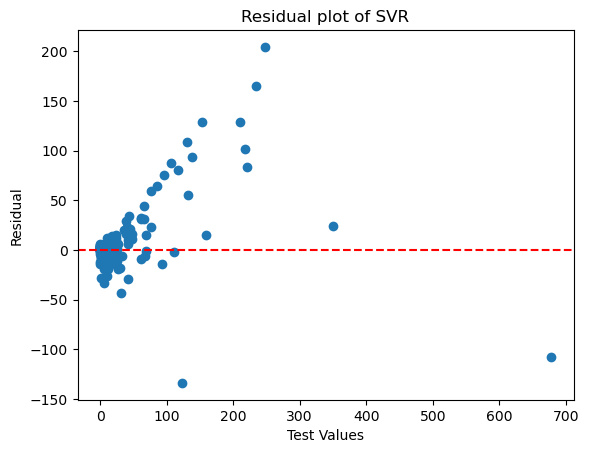

In [105]:
#Residual plot SVR
residuen = y_test - y_pred
plt.scatter(y_test, residuen)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Test Values')
plt.ylabel('Residual')
plt.title('Residual plot of SVR')
plt.savefig("SVR_Residual.jpg")
plt.show()



In [106]:
# cut of the outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


filtered_data = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]


In [107]:
#new model without outliers
drop_column = []
X = filtered_data.drop(["idle_time"] + drop_column, axis=1)  # Features
y = filtered_data['idle_time']  

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


svr_model = SVR(kernel='linear', C=10000.0, epsilon=0.1)

# training data
svr_model.fit(X_train_scaled, y_train)

# test data
y_pred = svr_model.predict(X_test_scaled)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean absolute Error (MAE):", mae)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 199165.77201645816
Mean absolute Error (MAE): 295.73337754847273
R-squared (R2): 0.48929478003313365


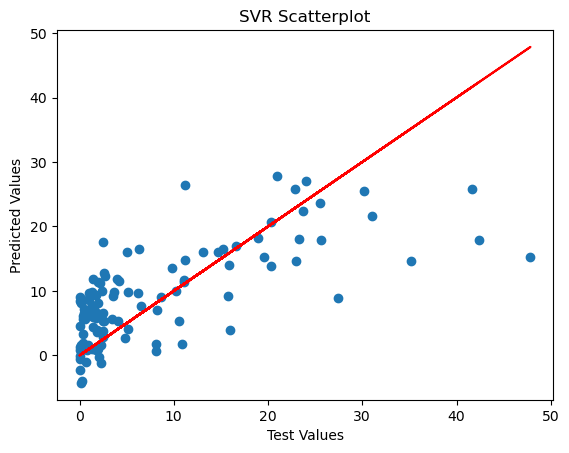

In [117]:
#Scatterplot SVR without outliers
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, c="r")
plt.xlabel('Test Values')
plt.ylabel('Predicted Values')
plt.title('SVR Scatterplot')
plt.savefig("SVR_Scatter_wo_outliers.jpg")
plt.show()


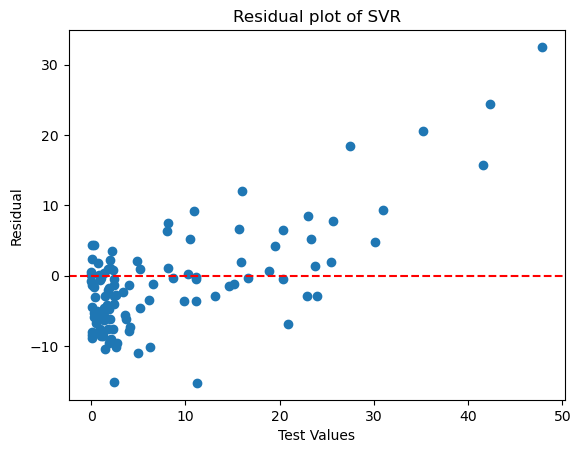

In [118]:
#Residual plot without outliers
residuen = y_test - y_pred
plt.scatter(y_test, residuen)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Test Values')
plt.ylabel('Residual')
plt.title('Residual plot of SVR')
plt.savefig("SVR_Residual_wo_outliers.jpg")
plt.show()



3940929.790102016
11586589.382894566
0.7562692581328925
0.2834157987043606
921.7773421994118
1352.9828586181413


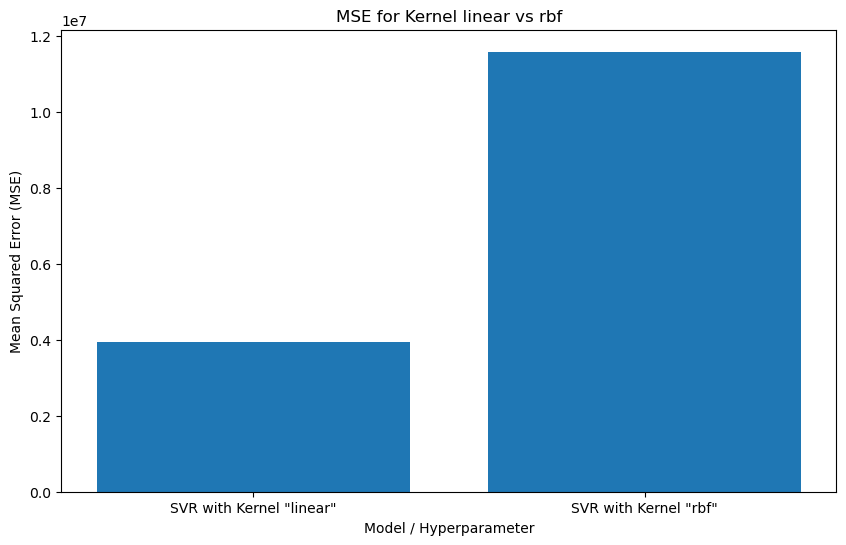

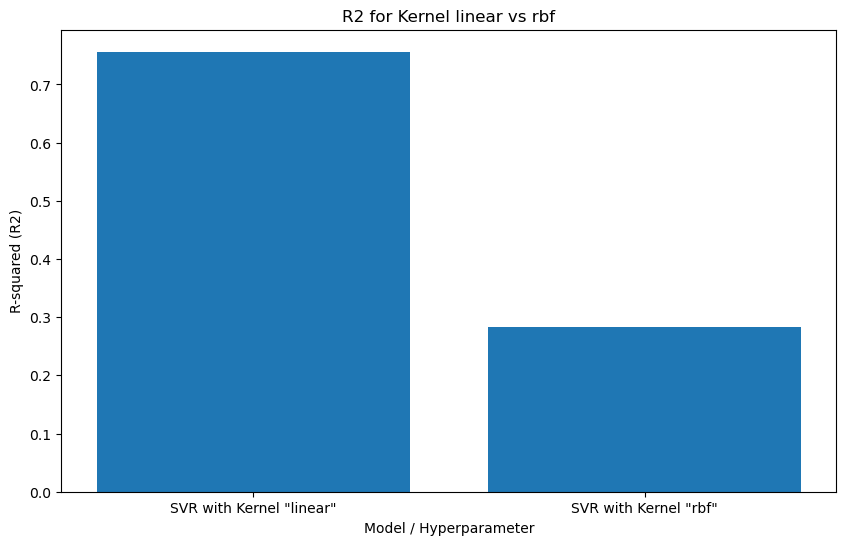

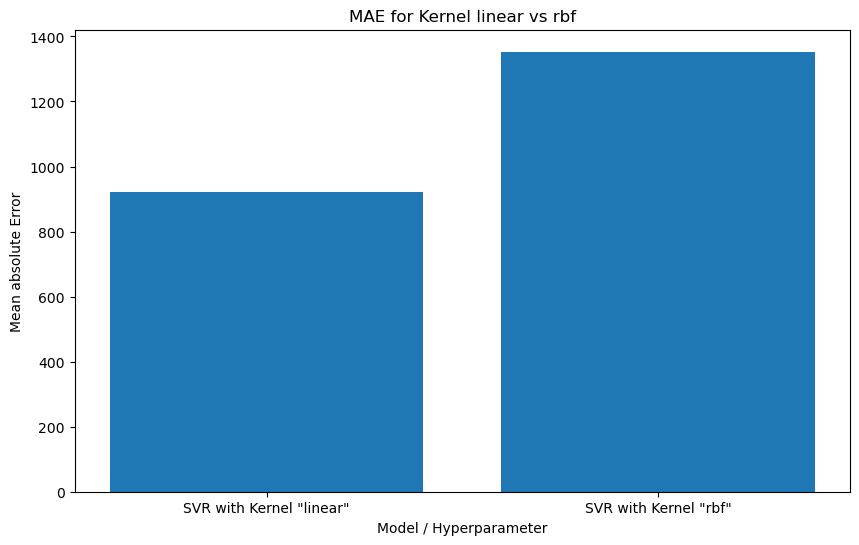

In [127]:
# model with two different kernel
drop_column = []
X = data.drop(['idle_time'] + drop_column, axis=1)  # Features
y = data['idle_time']  
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model
svr_linear = SVR(kernel='linear', C=100000, epsilon=0.1)
svr_rbf = SVR(kernel='rbf', C=100000, epsilon=0.1)

# Train
svr_linear.fit(X_train_scaled, y_train)
svr_rbf.fit(X_train_scaled, y_train)
#svr_poly.fit(X_train_scaled, y_train)

# Prediction 
y_pred_linear = svr_linear.predict(X_test_scaled)
y_pred_rbf = svr_rbf.predict(X_test_scaled)

# mse
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_rbf = mean_squared_error(y_test, y_pred_rbf)

print(mse_linear)
print(mse_rbf)

# r2
r2_linear = r2_score(y_test, y_pred_linear)
r2_rbf = r2_score(y_test, y_pred_rbf)

print(r2_linear)
print(r2_rbf)

#mae
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mae_rbf = mean_absolute_error(y_test, y_pred_rbf)

print(mae_linear)
print(mae_rbf)


model_names = ['SVR with Kernel "linear"', 'SVR with Kernel "rbf"']
mse_values = [mse_linear, mse_rbf ]
r2_values = [r2_linear, r2_rbf ]
mae_values = [mae_linear, mae_rbf]

#MSE
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_values)
plt.xlabel("Model / Hyperparameter")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE for Kernel linear vs rbf")
plt.savefig("SVR_different_kernel_MSE.jpg")
plt.show()

#R2
plt.figure(figsize=(10, 6))
plt.bar(model_names, r2_values)
plt.xlabel("Model / Hyperparameter")
plt.ylabel("R-squared (R2)")
plt.title("R2 for Kernel linear vs rbf")
plt.savefig("SVR_different_kernel_R2.jpg")
plt.show()

#MAE
plt.figure(figsize=(10, 6))
plt.bar(model_names, mae_values)
plt.xlabel("Model / Hyperparameter")
plt.ylabel("Mean absolute Error")
plt.title("MAE for Kernel linear vs rbf")
plt.savefig("SVR_different_kernel_MAE.jpg")
plt.show()



In [158]:
#LASSO Regression
X = data.drop("idle_time", axis=1)  # Features
y = data["idle_time"] / 60 

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train LASSO model
lasso_model = Lasso(alpha=15.0)  # alpha could be changed
lasso_model.fit(X_train_scaled, y_train)

# Test-data
y_pred = lasso_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Absolute Error: 18.06987446700896
Mean Squared Error (MSE): 1107.5634286740017
R-squared (R2): 0.7534058778390534


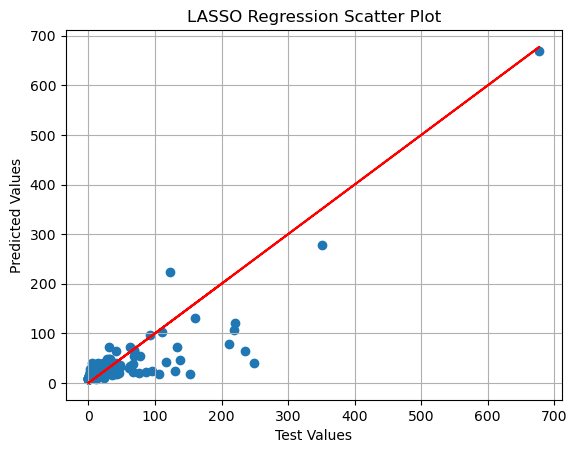

In [159]:
#Scatterplot LASSO
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, c="r")
plt.xlabel('Test Values')
plt.ylabel('Predicted Values')
plt.title('LASSO Regression Scatter Plot')
plt.grid()
plt.savefig("LASSO_Scatter.jpg")
plt.show()


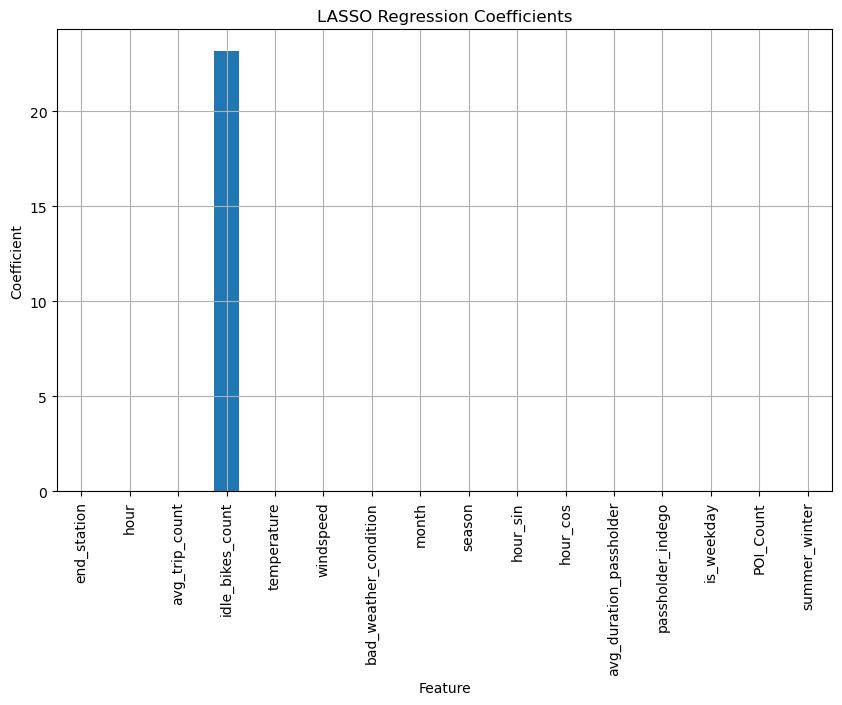

In [161]:
# Plot coefficients
coef = pd.Series(lasso_model.coef_, index=X.columns)
plt.figure(figsize=(10, 6))
coef.plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('LASSO Regression Coefficients')
plt.grid()
plt.savefig("LASSO_Coeff.png",bbox_inches='tight')
plt.show()


In [151]:
# cut of the outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


filtered_data = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]

In [163]:
# LASSO without outliers
X = filtered_data.drop("idle_time", axis=1)  # Features
y = filtered_data["idle_time"] / 60 

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train LASSO model
lasso_model = Lasso(alpha=0.1)  # alpha could be changed
lasso_model.fit(X_train_scaled, y_train)

# Test-data
y_pred = lasso_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Absolute Error: 5.6174685329369
Mean Squared Error (MSE): 57.773119739087235
R-squared (R2): 0.4666848590856053


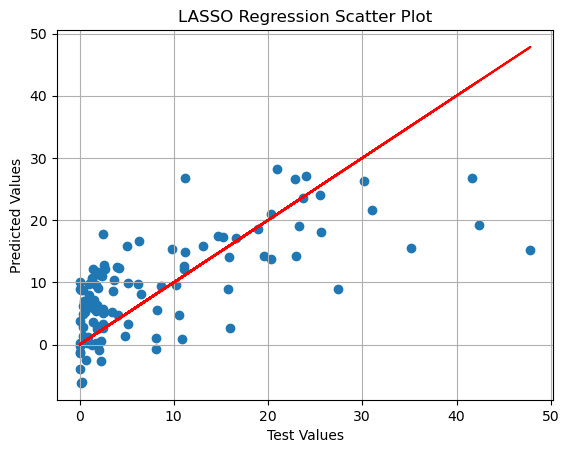

In [164]:
#Scatterplot LASSO without outliers
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, c="r")
plt.xlabel('Test Values')
plt.ylabel('Predicted Values')
plt.title('LASSO Regression Scatter Plot')
plt.grid()
plt.savefig("LASSO_Scatter_wo_outliers.jpg")
plt.show()



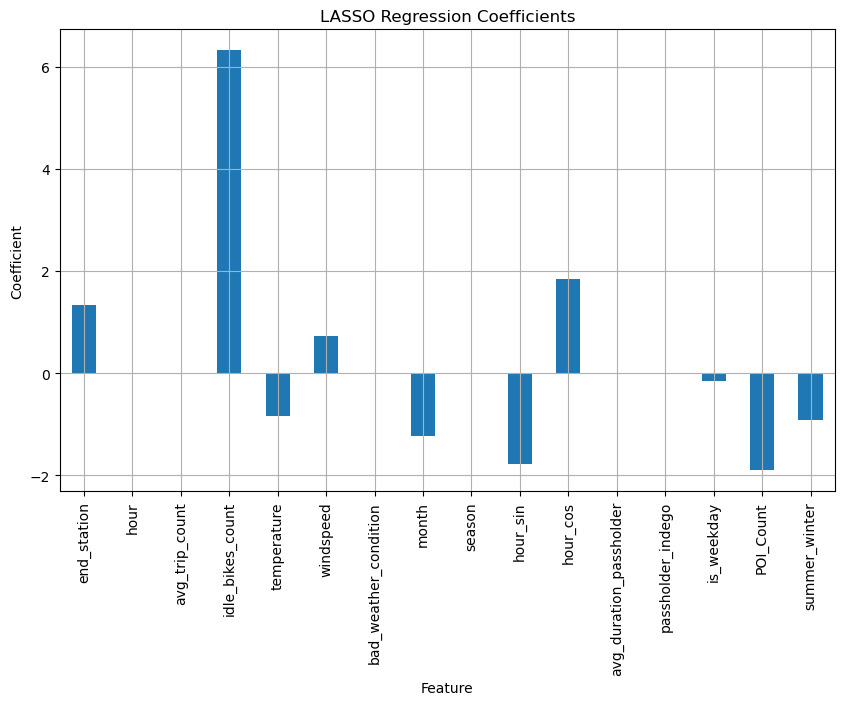

In [165]:
# Plot coefficients without outliers
coef = pd.Series(lasso_model.coef_, index=X.columns)
plt.figure(figsize=(10, 6))
coef.plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('LASSO Regression Coefficients')
plt.grid()
plt.savefig("LASSO_Coeff_wo_outliers.png",bbox_inches='tight')
plt.show()
